In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [2]:
task = 'aggression_score'

time: 1.52 ms


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 14.3 s


In [31]:
l_r = average(d_r[task].dropna())
l_b = average(d_b[task].dropna()).sample(len(l_r))

time: 84.6 ms


In [32]:
def mapl(l):
    if l < 0:
        return 1
    else:
        return 0
    
l_b = l_b.apply(mapl)
l_r = l_r.apply(mapl)

time: 9.43 ms


In [33]:
l_r.value_counts()

0    8303
1    1690
Name: y, dtype: int64

time: 2.92 ms


In [63]:
class_weight = dict(l_r.value_counts()/len(l_r))

time: 1.85 ms


In [34]:
l_b.value_counts()

1    6458
0    3535
Name: y, dtype: int64

time: 2.96 ms


In [35]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 103 ms


### Split into train/dev and test

In [36]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 17.7 ms


In [37]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.1 ms


In [38]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.31 ms


In [39]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

1

time: 10.9 ms


### NGram Classification Pipeline

In [33]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (0.0001, 0.01, 0.1, 1 ,5,10),
    #'clf__class_weight': ('balanced', None)
}

time: 6.26 ms


### Hyper-Parameter tuning

In [34]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)


Best parameters set found:
{'clf__C': 5, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'} 0.942947737662


Grid scores:
0.86564 (+/-0.00051) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.85497 (+/-0.00026) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.86205 (+/-0.00038) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 10000, 'vect__analyzer': 'char'}
0.87068 (+/-0.00055) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 50000, 'vect__analyzer': 'char'}
0.88167 (+/-0.00048) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.89039 (+/-0.00031) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.89365 (+/-0.00018) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_fea

In [65]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = 'balanced')),
])

time: 2 ms


### Train on blocked

In [66]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 13 s


Eval on blocked


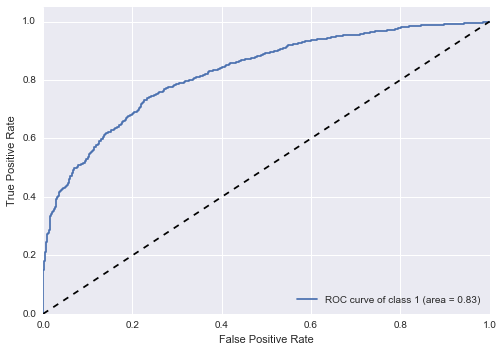

threshold @ optimal F1: 0.315690751277
{'optimal F1': '0.826',
 'precision @ optimal F1': '0.934',
 'recall @ optimal F1': '0.934',
 'roc': '0.827'}
time: 2.95 s


In [67]:
print('Eval on blocked')
_= eval_binary_classifier(b_model, b_test, calibration = False, roc = True)

Eval on random


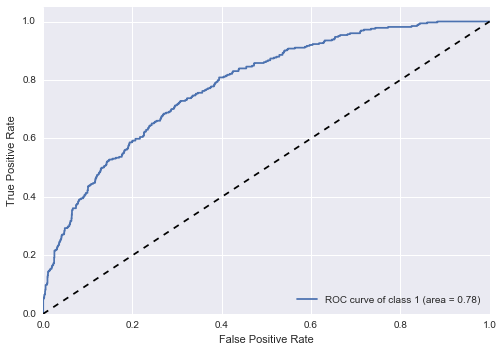

threshold @ optimal F1: 0.494009554722
{'optimal F1': '0.460',
 'precision @ optimal F1': '0.528',
 'recall @ optimal F1': '0.528',
 'roc': '0.784'}
time: 3.16 s


In [68]:
print('Eval on random')
_= eval_binary_classifier(b_model, r_test, calibration = False, roc = True)

### Train on random

In [81]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 13.1 s


Eval on blocked


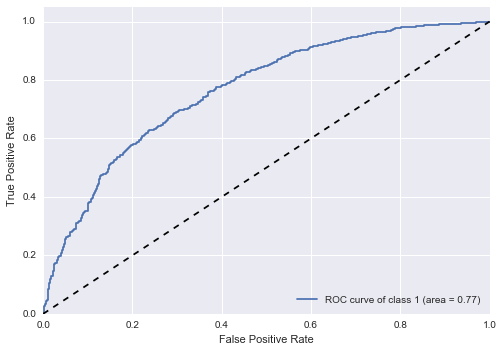

threshold @ optimal F1: 0.31033514669
{'optimal F1': '0.813',
 'precision @ optimal F1': '0.918',
 'recall @ optimal F1': '0.918',
 'roc': '0.766'}
time: 3.05 s


In [70]:
print('Eval on blocked')
_= eval_binary_classifier(r_model, b_test, calibration = False, roc = True)

Eval on random


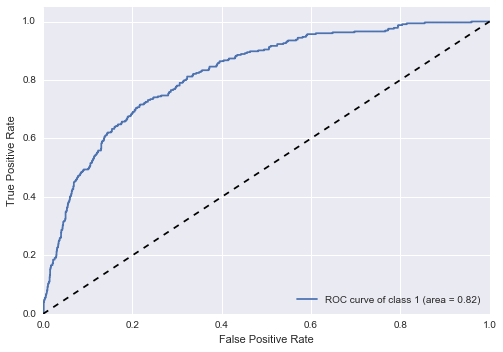

threshold @ optimal F1: 0.546720153734
{'optimal F1': '0.524',
 'precision @ optimal F1': '0.617',
 'recall @ optimal F1': '0.617',
 'roc': '0.823'}
time: 3.32 s


In [71]:
print('Eval on random')
_= eval_binary_classifier(r_model, r_test, calibration = False, roc = True)

### Train on both

In [72]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 26.1 s


Eval on blocked


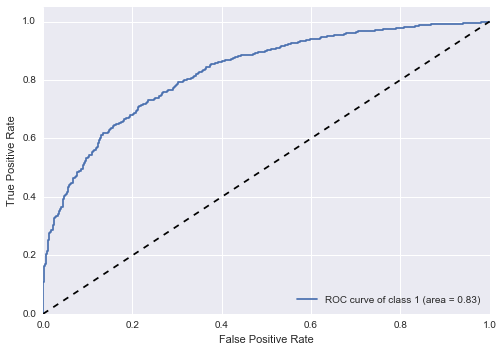

threshold @ optimal F1: 0.437653895589
{'optimal F1': '0.830',
 'precision @ optimal F1': '0.879',
 'recall @ optimal F1': '0.879',
 'roc': '0.828'}
time: 3.35 s


In [73]:
print('Eval on blocked')
_= eval_binary_classifier(br_model, b_test, calibration = False, roc = True)

Eval on random


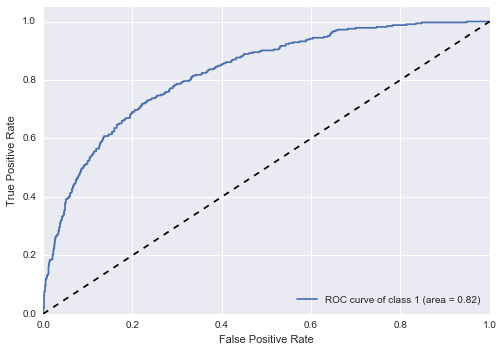

threshold @ optimal F1: 0.51103045637
{'optimal F1': '0.524',
 'precision @ optimal F1': '0.602',
 'recall @ optimal F1': '0.602',
 'roc': '0.825'}
time: 3.26 s


In [74]:
print('Eval on random')
_= eval_binary_classifier(br_model, r_test, calibration = False, roc = True)

Eval on both


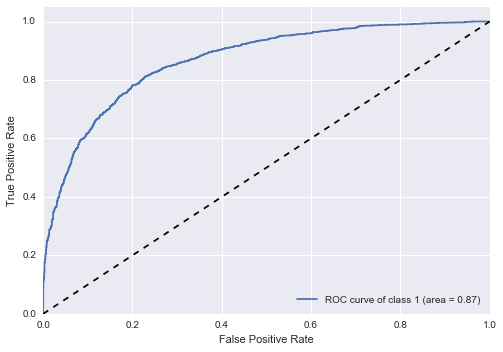

threshold @ optimal F1: 0.477068577505
{'optimal F1': '0.753',
 'precision @ optimal F1': '0.807',
 'recall @ optimal F1': '0.807',
 'roc': '0.868'}
time: 6.03 s


In [75]:
print('Eval on both')
_= eval_binary_classifier(br_model, br_test, calibration = False, roc = True)

### Check Calibration

threshold @ optimal F1: 0.477068577505
{'optimal F1': '0.753',
 'precision @ optimal F1': '0.807',
 'recall @ optimal F1': '0.807',
 'roc': '0.868'}


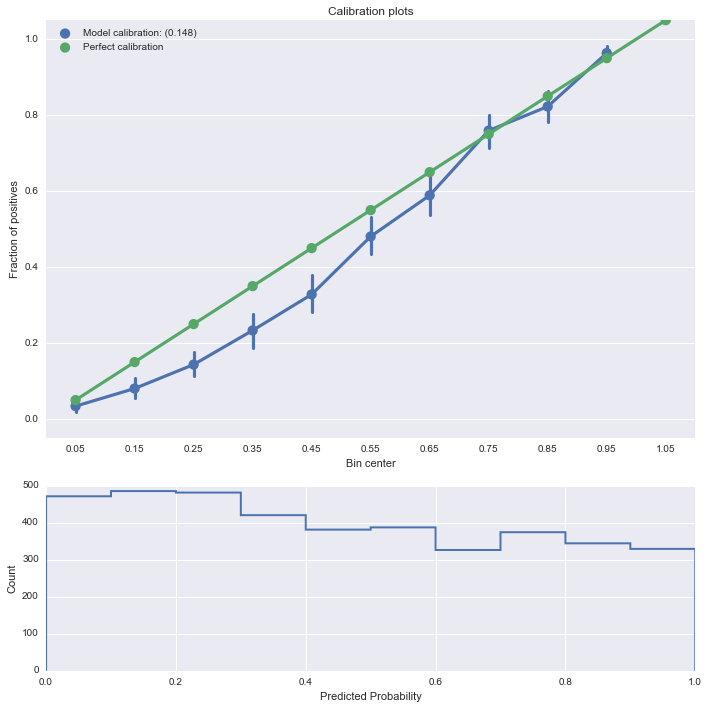

time: 6.73 s


In [76]:
_= eval_binary_classifier(br_model, br_test, calibration = True, roc = False)

threshold @ optimal F1: 0.437653895589
{'optimal F1': '0.830',
 'precision @ optimal F1': '0.879',
 'recall @ optimal F1': '0.879',
 'roc': '0.828'}


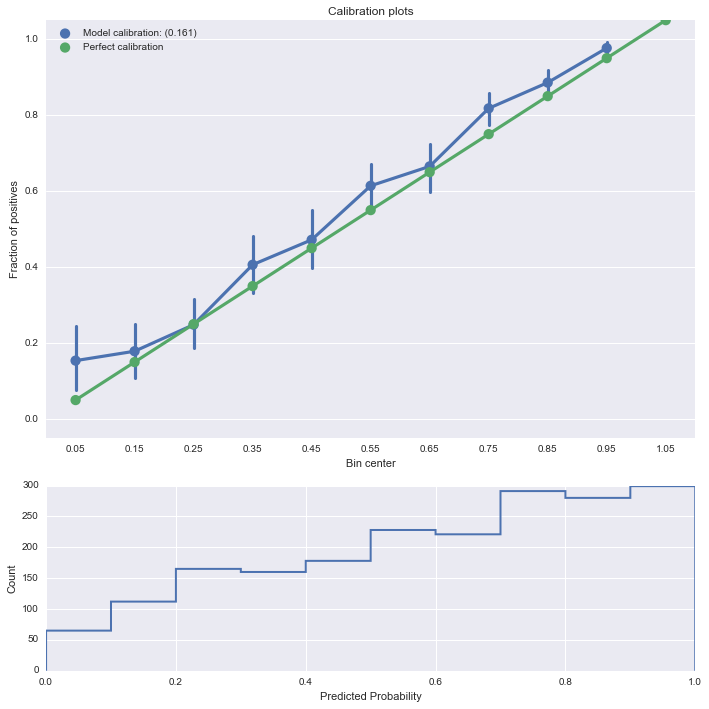

time: 3.4 s


In [77]:
_= eval_binary_classifier(br_model, b_test, calibration = True, roc = False)

threshold @ optimal F1: 0.51103045637
{'optimal F1': '0.524',
 'precision @ optimal F1': '0.602',
 'recall @ optimal F1': '0.602',
 'roc': '0.825'}


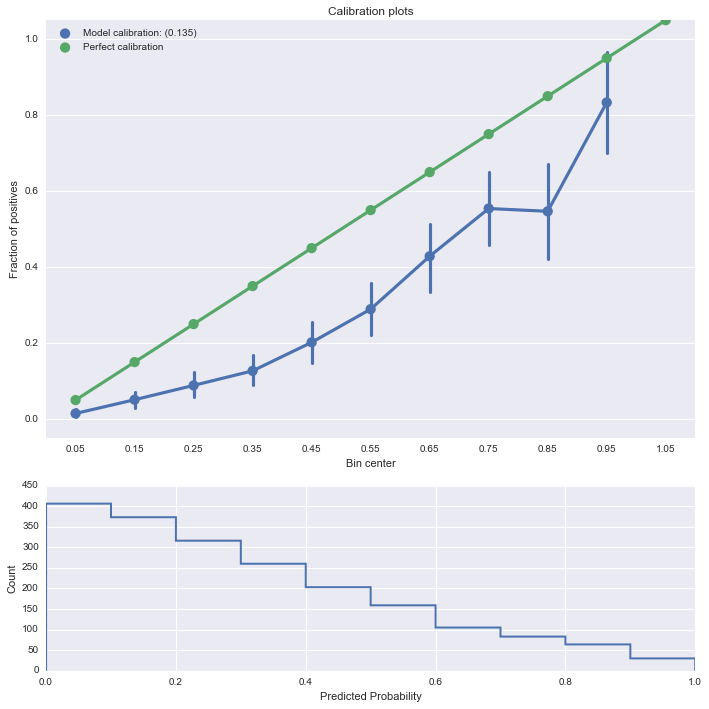

time: 3.84 s


In [78]:
_= eval_binary_classifier(br_model, r_test, calibration = True, roc = False)

threshold @ optimal F1: 0.546720153734
{'optimal F1': '0.524',
 'precision @ optimal F1': '0.617',
 'recall @ optimal F1': '0.617',
 'roc': '0.823'}


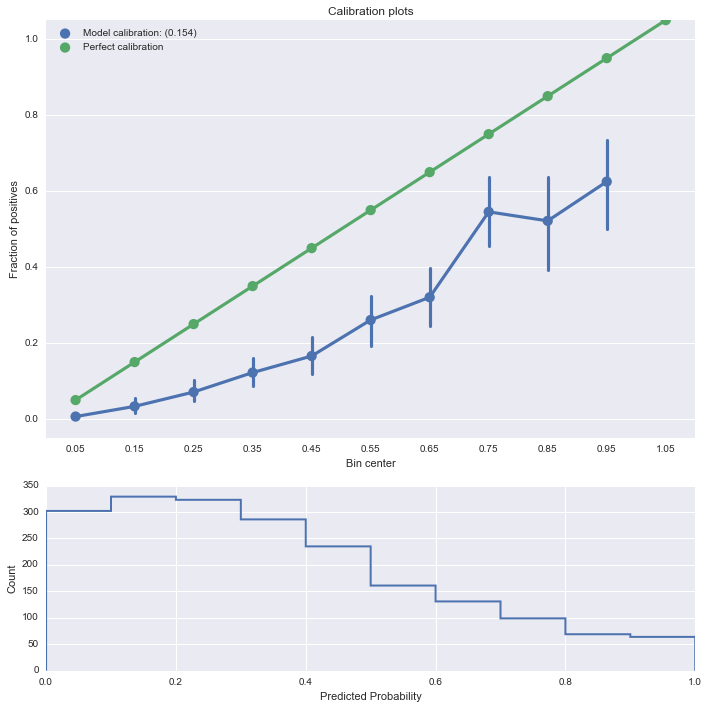

time: 3.74 s


In [82]:
_= eval_binary_classifier(r_model, r_test, calibration = True, roc = False)

### Error Analysis

In [ ]:
fn, fp = get_clf_errors(br_model, br_test)

In [ ]:
# extreme False negatives
print_clf_errors(fn)

In [ ]:
# extreme False positives
print_clf_errors(fp)

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked dat as we add more training data.

In [37]:
def get_roc(model, test):
    return roc_auc_score(test['y'], model.predict_proba(test['x'])[:, 1])

time: 19.7 ms


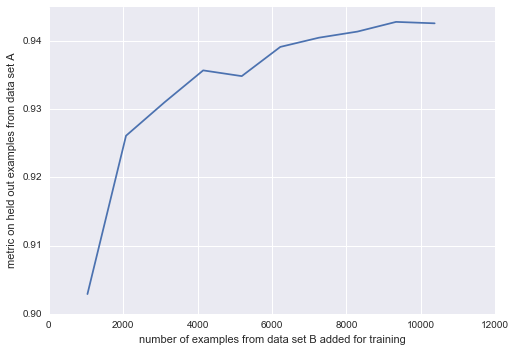

time: 5min 22s


In [28]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc, test_size = 0.5)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

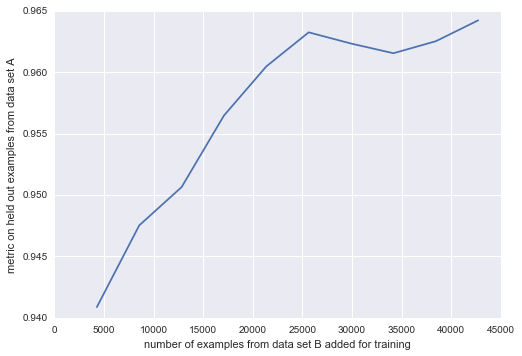

time: 9min 9s


In [38]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc, test_size = 0.8)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

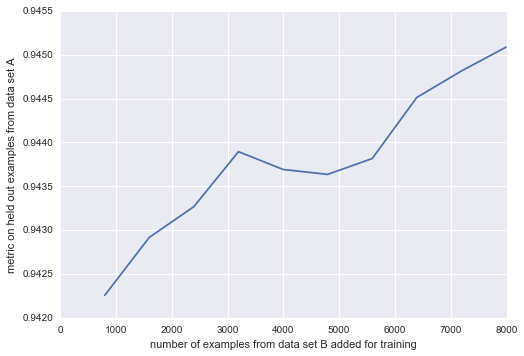

time: 23min 2s


In [30]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc, test_size = 0.8)
plot_adding_other_data(ms, metrics)

# Final Model

In [36]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 1min 50s


# Model Understanding

In [55]:
understanding_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1), analyzer = 'word', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = None)),
])

time: 1.95 ms


In [126]:
model = understanding_pipeline.fit(br_train['x'], br_train['y'])

time: 3.27 s


In [127]:
clf = model.named_steps['clf']

time: 800 µs


In [128]:
coef_ = clf.coef_.ravel()

time: 957 µs


In [129]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())

time: 14.7 ms


In [130]:
most_pos_idx = np.argsort(coef_)[-100:]
most_pos = feature_names[most_pos_idx]

time: 1.72 ms


In [131]:
most_neg_idx = np.argsort(coef_)[:100]
most_neg = feature_names[most_neg_idx]

time: 1.82 ms


In [132]:
most_pos

array(['damn', 'quit', 'shove', 'arsehole', 'dicks', 'nazis', 'ты',
       'homosexual', 'fat', 'pig', 'fuc', 'stop', 'disgusting', 'anal',
       'face', 'yo', 'hate', 'fc', 'retarded', 'piss', 'lick', 'arse',
       'douche', 'head', 'wanker', 'smell', 'dickhead', 'jackass', 'penis',
       'balls', 'ck', 'fuckers', 'arrogant', 'life', 'nazi', 'pussy',
       'prick', 'ing', 'are', 'nigga', 'jerk', 'sex', 'youre', 'hole',
       'fuk', 'scum', 'nigger', 'gay', 'idiotic', 'yourself', 'douchebag',
       'kiss', 'little', 'fuckin', 'loser', 'fag', 'screw', 'dumbass',
       'bullshit', 'pathetic', 'ugly', 'cocksucker', 'coward', 'crap',
       'hypocrite', 'assholes', 'ignorant', 'hell', 'ur', 'idiots',
       'motherfucker', 'retard', 'kill', 'dumb', 'fuckhead', 'racist',
       'go', 'fucked', 'fool', 'off', 'faggot', 'cock', 'die', 'cunt',
       'shut', 'fucker', 'bastard', 'dick', 'ass', 'moron', 'bitch',
       'shit', 'suck', 'your', 'asshole', 'stupid', 'idiot', 'fucking',
    

time: 1.99 ms


In [133]:
most_neg

array(['thank', 'help', 'thanks', 'please', 'he', 'talk', 'to', 'they',
       'this', 'for', 'user', 'appreciate', 'if', 'song', 'articles',
       'issue', 'but', 'request', 'hi', 'him', 'welcome', 'love',
       'discussion', 'the', 'see', 'interested', 'billcj', 'against',
       'position', 'agree', 'username', 'comment', 'continue', 'suggest',
       'understand', 'might', 'at', 'reported', 'these', 'rfa', 'can',
       'great', 'cannot', 'riot', 'interesting', 'cool', 'notice', 'title',
       'section', 'editing', 'should', 'questions', 'hes', 'utc',
       'knowledge', 'al', 'is', 'saying', 'fix', 'article', 'work',
       'could', 'cheers', 'yes', 'response', 'we', 'also', 'there',
       'blocked', 'new', 'particular', 'from', 'music', 'dreadstar',
       'once', 'notable', 'through', 'simply', 'his', '2006',
       'contributions', 'summaries', 'currently', 'evidence', 'would',
       'january', 'link', 'more', 'luck', 'done', 'list', 'include',
       'worry', 'did', 'poin

time: 1.85 ms


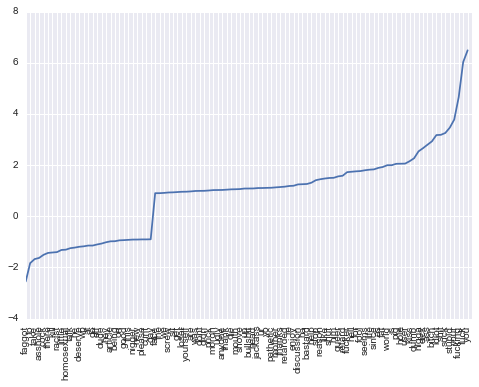

time: 644 ms


In [117]:
"""
coef = coef_.ravel()[important]
inds = np.argsort(coef)
f_imp = f_imp[inds]
coef = coef[inds]
plt.plot(coef, label="l1")
ax = plt.gca()
ax.set_xticks(np.arange(len(coef)))
labels = ax.set_xticklabels(f_imp)
for label in labels:
    label.set_rotation(90)
plt.show()

"""